In [2]:
## CMP6228 Assesment Implementation

## GAN Bi-LSTM AAPL Closing Price Forecast Model ##

## Author: Gokulan Vigneswaran

## Student ID: 20136713

## To Test without GAN after ingestion go straight to preprocessing for BiLSTM##

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Bidirectional
from tensorflow import keras as k
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU
from keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import sklearn as sklearn



In [4]:
# Data Ingestion and Preprocessing for GAN

# Get the stock symbol
STOCK_SYMBOL = 'AAPL'

# Get the data
data = yf.download(STOCK_SYMBOL, start='2010-01-01', end='2023-05-15')

# Print the data
print(data)

# Split the data into train and test sets
train_data = data.loc['2010-01-01': '2020-12-31']
test_data = data.loc['2021-01-01': '2022-03-08']

# Create a separate scaler for 'Close' prices
close_scaler = MinMaxScaler()
train_close_scaled = close_scaler.fit_transform(train_data['Close'].values.reshape(-1, 1))
test_close_scaled = close_scaler.transform(test_data['Close'].values.reshape(-1, 1))

# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values)
test_data_normalized = scaler.transform(test_data.values)

# Replace the 'Close' column in normalized data with separately scaled 'Close' prices
train_data_normalized[:, 3] = train_close_scaled.ravel()
test_data_normalized[:, 3] = test_close_scaled.ravel()


[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04    7.622500    7.660714    7.585000    7.643214    6.496294   
2010-01-05    7.664286    7.699643    7.616071    7.656429    6.507526   
2010-01-06    7.656429    7.686786    7.526786    7.534643    6.404016   
2010-01-07    7.562500    7.571429    7.466071    7.520714    6.392177   
2010-01-08    7.510714    7.571429    7.466429    7.570714    6.434674   
...                ...         ...         ...         ...         ...   
2023-05-08  172.479996  173.850006  172.110001  173.500000  173.260345   
2023-05-09  173.050003  173.539993  171.600006  171.770004  171.532745   
2023-05-10  173.020004  174.029999  171.899994  173.559998  173.320267   
2023-05-11  173.850006  174.589996  172.169998  173.750000  173.510010   
2023-05-12  173.619995  174.059998  171.000

In [5]:
# Create the generator
generator = Sequential()
generator.add(Dense(128, input_dim=1))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Dense(64))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Dense(1))

# Compile the generator
generator.compile(loss='mean_squared_error', optimizer='adam')

# Create the discriminator
discriminator = Sequential()
discriminator.add(LSTM(64, input_shape=(train_data.shape[1], 1), return_sequences=True))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(1, activation='sigmoid'))


# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create the GAN
gan = Sequential()
gan.add(generator)
gan.add(discriminator)

# Compile the GAN
gan.compile(loss='binary_crossentropy', optimizer='adam')



87/87 [==============================] - 3s 1ms/step
Epoch 1/100
D loss: 0.5857676118612289
G loss: 0.691878080368042
87/87 [==============================] - 0s 1ms/step
Epoch 2/100
D loss: 0.5723555088043213
G loss: 0.6906514167785645
87/87 [==============================] - 0s 1ms/step
Epoch 3/100
D loss: 0.5597880631685257
G loss: 0.6894188523292542
87/87 [==============================] - 0s 1ms/step
Epoch 4/100
D loss: 0.5452250987291336
G loss: 0.688051700592041
87/87 [==============================] - 0s 1ms/step
Epoch 5/100
D loss: 0.5351543575525284
G loss: 0.6866022944450378
87/87 [==============================] - 0s 1ms/step
Epoch 6/100
D loss: 0.5257015824317932
G loss: 0.6849854588508606
87/87 [==============================] - 0s 1ms/step
Epoch 7/100
D loss: 0.516675591468811
G loss: 0.6833018660545349
87/87 [==============================] - 0s 1ms/step
Epoch 8/100
D loss: 0.5082877725362778
G loss: 0.6814688444137573
87/87 [==============================] - 0s 2ms/ste

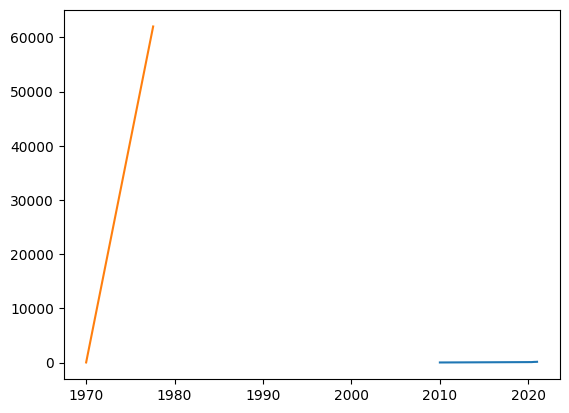

In [6]:
# Train the GAN
epochs = 100
for epoch in range(epochs):
    # Train the discriminator
    real_data = train_data.values
    fake_data = generator.predict(np.random.rand(len(real_data), 1))
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((len(real_data), 1)))[0]
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((len(fake_data), 1)))[0]
    d_loss = (d_loss_real + d_loss_fake) / 2



    # Freeze discriminator weights
    discriminator.trainable = False

    # Train the generator
    g_loss = gan.train_on_batch(np.random.rand(len(real_data), 1), np.ones((len(real_data), 1)))

    # Unfreeze discriminator weights
    discriminator.trainable = True

    # Print the losses
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    print('D loss: {}'.format(d_loss))
    print('G loss: {}'.format(g_loss))

# Plot the generated data
plt.plot(train_data['Close'])
plt.plot(generator.predict(np.arange(0, len(train_data), 1)))
plt.show()


In [7]:
##############Generate Synthetic Data and Combine with Testing Set##############

num_samples = 1000  # Number of synthetic samples to generate
num_columns = train_data.shape[1]  # Number of columns in the original training data

# Generate synthetic data
random_inputs = np.random.rand(num_samples, 1)
synthetic_data = generator.predict(random_inputs)

# Reshape synthetic data
num_rows = num_samples // num_columns  # Floor division
synthetic_data_reshaped = synthetic_data[:num_rows * num_columns].reshape(num_rows, num_columns)

# Denormalize the synthetic data
synthetic_data_denormalized = scaler.inverse_transform(synthetic_data_reshaped)

# Combine synthetic data with training set
combined_data = np.concatenate((train_data_normalized, synthetic_data_denormalized), axis=0)


32/32 [==============================] - 0s 1ms/step


**Run box below when testing without GAN**

In [32]:
##For testing without synthetic data
combined_data = train_data_normalized

In [8]:
############ Data Preprocessing for Bi-LSTM#############

df = combined_data

# Define the sizes of the training, validation, and synthetic data sets
training_size = int(len(df) * 0.85)  # allocate 85% of the data to training
validation_size = len(df) - training_size # allocate the rest to validation

n_features = df.shape[1]  # number of features in the data

# Prepare training data
train_data = df[:training_size]
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 3])  # selecting 'Close' price
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_features))

# Prepare validation data
validation_data = df[training_size:]
x_validation = []
y_validation = []
if len(validation_data) >= 60:  # Check if there are enough data points to create a 3D array
    for i in range(60, len(validation_data)):
        x_validation.append(validation_data[i-60:i])
        y_validation.append(validation_data[i, 3])  # selecting 'Close' price
    x_validation = np.array(x_validation)
    y_validation = np.array(y_validation)
    x_validation = np.reshape(x_validation, (x_validation.shape[0], x_validation.shape[1], n_features))
else:
    print("Not enough data points for validation set.")

# Prepare separate testing data
scaled_test_data = test_data_normalized
x_test = []
y_test = []
if len(scaled_test_data) >= 60:  # Check if there are enough data points to create a 3D array
    for i in range(60, len(scaled_test_data)):
        x_test.append(scaled_test_data[i-60:i])
        y_test.append(scaled_test_data[i, 3])  # selecting 'Close' price
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_features))
else:
    print("Not enough data points for testing set.")



In [9]:
############Training Bi-LSTM#############

root_mean_squared_error = tf.keras.metrics.RootMeanSquaredError()
r2_score = sklearn.metrics.r2_score

# Build Bi-LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=False, input_shape=(x_train.shape[1], 1))))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_squared_error', metrics=[ root_mean_squared_error, 'mean_absolute_error'])

# Define a function to calculate RMSE
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

# Define a function to calculate R2 score
def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

# Train the model
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=32, epochs=50)




Epoch 1/50
77/77 [==============================] - 7s 25ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000 - mean_absolute_error: 0.0590 - val_loss: 4695840.5000 - val_root_mean_squared_error: 2166.9888 - val_mean_absolute_error: 1378.8722
Epoch 2/50
77/77 [==============================] - 1s 14ms/step - loss: 4.0802e-04 - root_mean_squared_error: 0.0202 - mean_absolute_error: 0.0139 - val_loss: 4695388.0000 - val_root_mean_squared_error: 2166.8843 - val_mean_absolute_error: 1378.7628
Epoch 3/50
77/77 [==============================] - 2s 23ms/step - loss: 2.3892e-04 - root_mean_squared_error: 0.0155 - mean_absolute_error: 0.0110 - val_loss: 4695393.0000 - val_root_mean_squared_error: 2166.8855 - val_mean_absolute_error: 1378.7363
Epoch 4/50
77/77 [==============================] - 1s 12ms/step - loss: 1.7086e-04 - root_mean_squared_error: 0.0131 - mean_absolute_error: 0.0096 - val_loss: 4695298.5000 - val_root_mean_squared_error: 2166.8638 - val_mean_absolute_error: 1378.7124


In [35]:
predictions = model.predict(x_test)
print("Predictions shape:", predictions.shape)
print("Test set shape:", y_test.shape)
print("Number of features in scaler:", scaler.scale_.shape[0])


12/12 [==============================] - 1s 4ms/step
Predictions shape: (364, 1)
Test set shape: (364,)
Number of features in scaler: 6


77/77 [==============================] - 0s 4ms/step


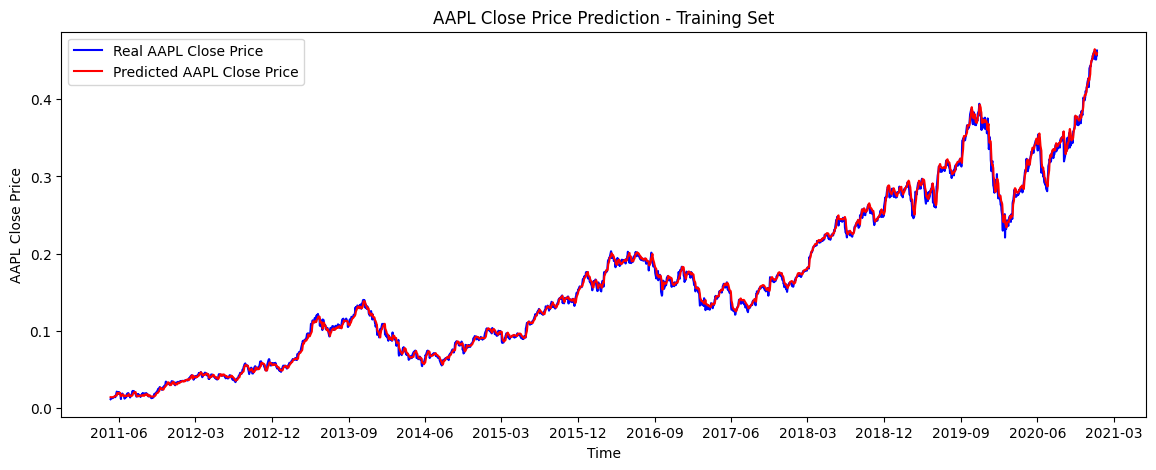

In [10]:
######### Training Forecasts ##########

# Make predictions on the test set
predictions = model.predict(x_train)

# The output of the predict method will be scaled since the inputs were also scaled. 
# So, apply inverse transformation to get prices in the original scale:
predictions_original_scale = close_scaler.inverse_transform(predictions)

# Get the real 'Close' prices from the test data
real_close_prices = close_scaler.inverse_transform(y_train.reshape(-1, 1))

# Define the training_data
train_data = data.loc['2010-01-01': '2020-12-31']

# Extract the dates for the test data
training_dates = train_data.index

# Rescale the predictions to the original scale
predictions_original_scale = close_scaler.inverse_transform(predictions)

# Slice the training_dates to have the same length as y_train
training_dates = training_dates[60:]

# Get the length of y_train
n = len(y_train)

# Adjust training_dates to match the length of y_train
training_dates = training_dates[-n:]

# Plot the data
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(training_dates, y_train, color='blue', label='Real AAPL Close Price')
ax.plot(training_dates, model.predict(x_train), color='red', label='Predicted AAPL Close Price')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=9))  # to display dates with 6-month interval
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # to display dates in 'YYYY-mm' format

plt.title('AAPL Close Price Prediction - Training Set')
plt.xlabel('Time')
plt.ylabel('AAPL Close Price')
plt.legend()
plt.show()


8/8 [==============================] - 0s 4ms/step


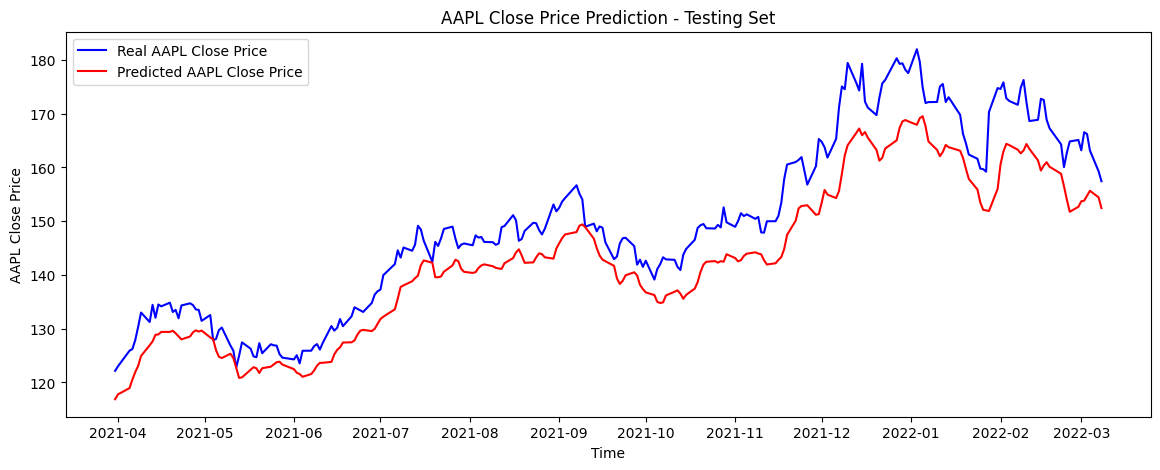

In [11]:
######### Testing Forecasts ##########

# Make predictions on the test set
predictions = model.predict(x_test)

# The output of the predict method will be scaled since the inputs were also scaled. 
# So, apply inverse transformation to get prices in the original scale:
predictions_original_scale = close_scaler.inverse_transform(predictions)

# Get the real 'Close' prices from the test data
real_close_prices = close_scaler.inverse_transform(y_test.reshape(-1, 1))


# Extract the dates for the test data
test_dates = test_data.index

# Rescale the predictions to the original scale
predictions_original_scale = close_scaler.inverse_transform(predictions)

# Slice the test_dates to have the same length as y_test
test_dates = test_dates[60:]

# Plot the data
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(test_dates, real_close_prices, color='blue', label='Real AAPL Close Price')
ax.plot(test_dates, predictions_original_scale, color='red', label='Predicted AAPL Close Price')
ax.xaxis.set_major_locator(mdates.MonthLocator())  # to display dates with monthly interval
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # to display dates in 'YYYY-mm' format

plt.title('AAPL Close Price Prediction - Testing Set')
plt.xlabel('Time')
plt.ylabel('AAPL Close Price')
plt.legend()
plt.show()


77/77 [==============================] - 0s 3ms/step
Train set MSE: 942.17
Train set RMSE: 30.69
Train set MAE: 27.63
Train set R^2: -89094.39
8/8 [==============================] - 0s 5ms/step
Test set MSE: 20252.29
Test set RMSE: 142.31
Test set MAE: 141.64
Test set R^2: -1316608.63


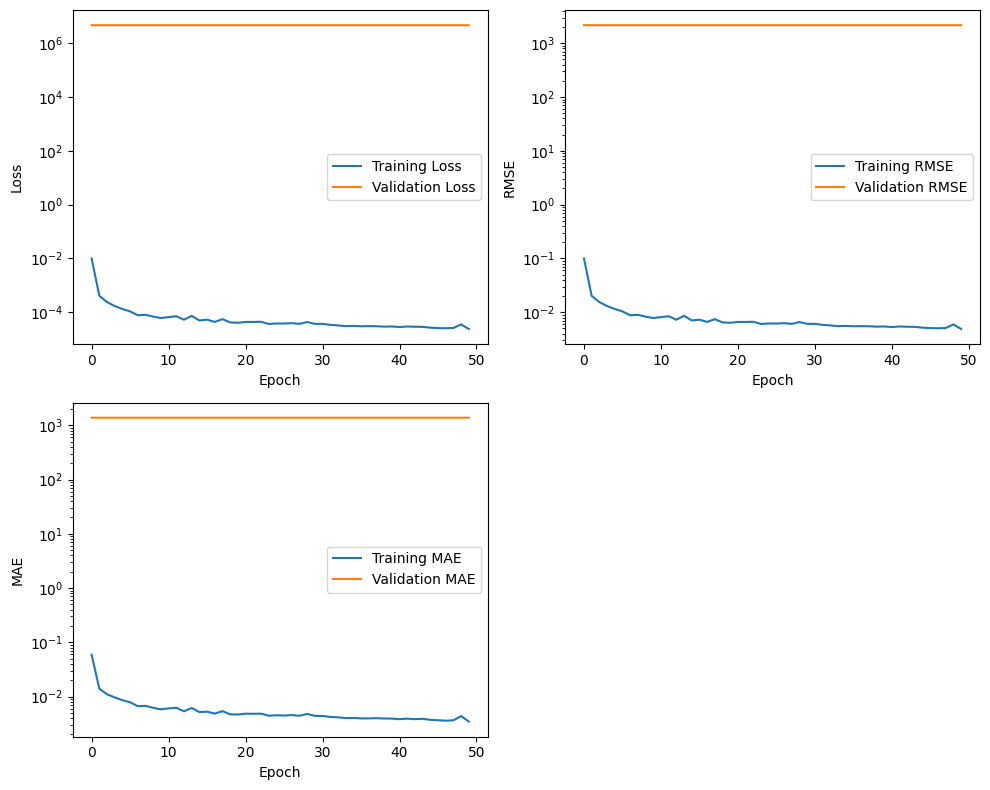

In [12]:
############ Training Performance Evaluation #############

# Make predictions on the train set
predictions = model.predict(x_train)
predictions = close_scaler.inverse_transform(predictions)

# Calculate metrics on the train set
mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, predictions)
r2 = r2_score(y_train, predictions)

print(f"Train set MSE: {mse:.2f}")
print(f"Train set RMSE: {rmse:.2f}")
print(f"Train set MAE: {mae:.2f}")
print(f"Train set R^2: {r2:.2f}")


############ Testing Performance Evaluation #############

# Make predictions on the test set
predictions = model.predict(x_test)
predictions = close_scaler.inverse_transform(predictions)

# Calculate metrics on the test set
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Test set MSE: {mse:.2f}")
print(f"Test set RMSE: {rmse:.2f}")
print(f"Test set MAE: {mae:.2f}")
print(f"Test set R^2: {r2:.2f}")


##### Plot all metrics during training #####
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Remove the last plot
fig.delaxes(axs[1, 1])

axs[0, 0].plot(history.history['loss'], label='Training Loss')
axs[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].set_yscale('log')  # Use logarithmic scale

axs[0, 1].plot(history.history['root_mean_squared_error'], label='Training RMSE')
axs[0, 1].plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('RMSE')
axs[0, 1].legend()
axs[0, 1].set_yscale('log')  # Use logarithmic scale

axs[1, 0].plot(history.history['mean_absolute_error'], label='Training MAE')
axs[1, 0].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].legend()
axs[1, 0].set_yscale('log')  # Use logarithmic scale

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()
